### 1.计算给定数据集的香农熵

In [2]:
import numpy as np
import math
from math import log
def shannonEntropy(dataSet):
    num = len(dataSet)
    classCount = {}
    for a in dataSet:
        label = a[-1]#最后一列为类别标签
        classCount[label] = classCount.get(label,0)+1
    shangnon = 0.0
    for key in classCount:
        prob = float(classCount[key])/num
        shangnon += -prob*log(prob,2)#香农熵计算公式
    return shangnon

In [3]:
dataSet = [[1,1,'yes'],
          [1,1,'yes'],
          [1,0,'no'],
          [0,1,'no'],
          [0,1,'no']]
shangnon = shannonEntropy(dataSet)
shangnon

0.9709505944546686

### 2.以某个特征及其属性值划分数据集

In [4]:
def splitDataSet(dataSet,feature_index,feature_value):
    subDataSet = []
    for b in dataSet:
        if b[feature_index]==feature_value:
            temp = b[:feature_index]#注意这里不能直接用del删除而应该用切片，用del原数据集会改变
            temp.extend(b[feature_index+1:])
            subDataSet.append(temp)
    return subDataSet

In [5]:
splitDataSet(dataSet,0,1)#以第一个特征划分，如果数据集中样本第一个特征为1，则去掉第一个特征，保留其它特征和类别标签

[[1, 'yes'], [1, 'yes'], [0, 'no']]

### 3.选择最好的特征作为根节点划分数据

In [6]:
def selectRootNode(dataSet):
    baseEntropy = shannonEntropy(dataSet)#计算原始香农熵
    numFeatures = len(dataSet[0])-1#特征个数
    maxInfoGain = 0.0;bestFeature = 0
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqVals = set(featList)
        newEntropy = 0.0
        for j in uniqVals:
            subDataSet = splitDataSet(dataSet,i,j)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * shannonEntropy(subDataSet)
        infoGain = baseEntropy - newEntropy#信息增益
        if(infoGain>maxInfoGain):
            maxInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [7]:
selectRootNode(dataSet)

0

In [8]:
#如果数据集已经处理完了所有属性，叶子节点中类别标签还不是唯一的，通常会选择最多的类别当成叶子节点的分类。
def majorityCnt(classList):
    leafDict = {}
    for i in classList:
        leafDict[i] = leafDict.get(i,0)+1
    result = sorted(leafDict.items(),key = lambda x:x[0],reverse=True)
    return result[0][0]

In [9]:
majorityCnt(['yes','yes','no'])

'yes'

### 4.创建树

In [10]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    bestFeat = selectRootNode(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del labels[bestFeat]
    featValues = [example[bestFeat] for example in dataSet]
    uniqValues = set(featValues)
    for i in uniqValues:
        subLabels = labels[:]
        myTree[bestFeatLabel][i] = createTree(splitDataSet(dataSet,bestFeat,i),subLabels)
    return myTree

In [11]:
labels = ['no surface','flippers']
myTree = createTree(dataSet,labels)
myTree

{'no surface': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### 5.使用决策树执行分类

In [12]:
def classifier(myTree,featLabels,testVec):
    firstFeat = list(myTree.keys())[0]
    secondDict = myTree[firstFeat]
    featIndex = featLabels.index(firstFeat)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classifier(secondDict[key],featLabels,testVec)
            else:classLabel = secondDict[key]
    return classLabel    

In [13]:
featLabels = ['no surface','flippers']
testVec = [1,0]
classifier(myTree,featLabels,testVec)

'no'

### 6.决策树的存储
#构造决策树是很耗时的任务，而用创建好的决策树来处理分类问题，则可以很快完成。因此，为了节约时间，将构造好的决策树保存起来，下次用的时候直接导进来调用就好了

In [14]:
#使用pickle模块将树结构保存成文件
def storeTree(myTree,filename):
    import pickle
    fw = open(filename,'wb')
    pickle.dump(myTree,fw)
    fw.close()
# 使用pickle模块导入树结构文件 
def grabTree(filename):
    import pickle
    fr = open(filename,'rb')
    return pickle.load(fr)

In [15]:
storeTree(myTree,'myTree.txt')
grabTree('myTree.txt')

{'no surface': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### 7.画树形图

In [16]:
#画iris数据集的树形图
from sklearn.datasets import load_iris
from sklearn import tree
clf = tree.DecisionTreeClassifier()
iris = load_iris()
clf = clf.fit(iris.data, iris.target)

### 一、安装Graphviz
#下载网站：http://www.graphviz.org/Download
#添加环境变量在系统环境变量path中将Graphviz的bin的目录路径添加上；

#如果我们安装了Python模块pydotplus，我们可以直接在Python中生成PDF文件（或任何其他支持的文件类型）
#安装pydotplus在Anaconda Prompt中输入:conda install -c conda-forge pydotplus

In [17]:
#将树形图生成PDF文件
import pydotplus
dot_data = tree.export_graphviz(clf, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("iris.pdf")

True

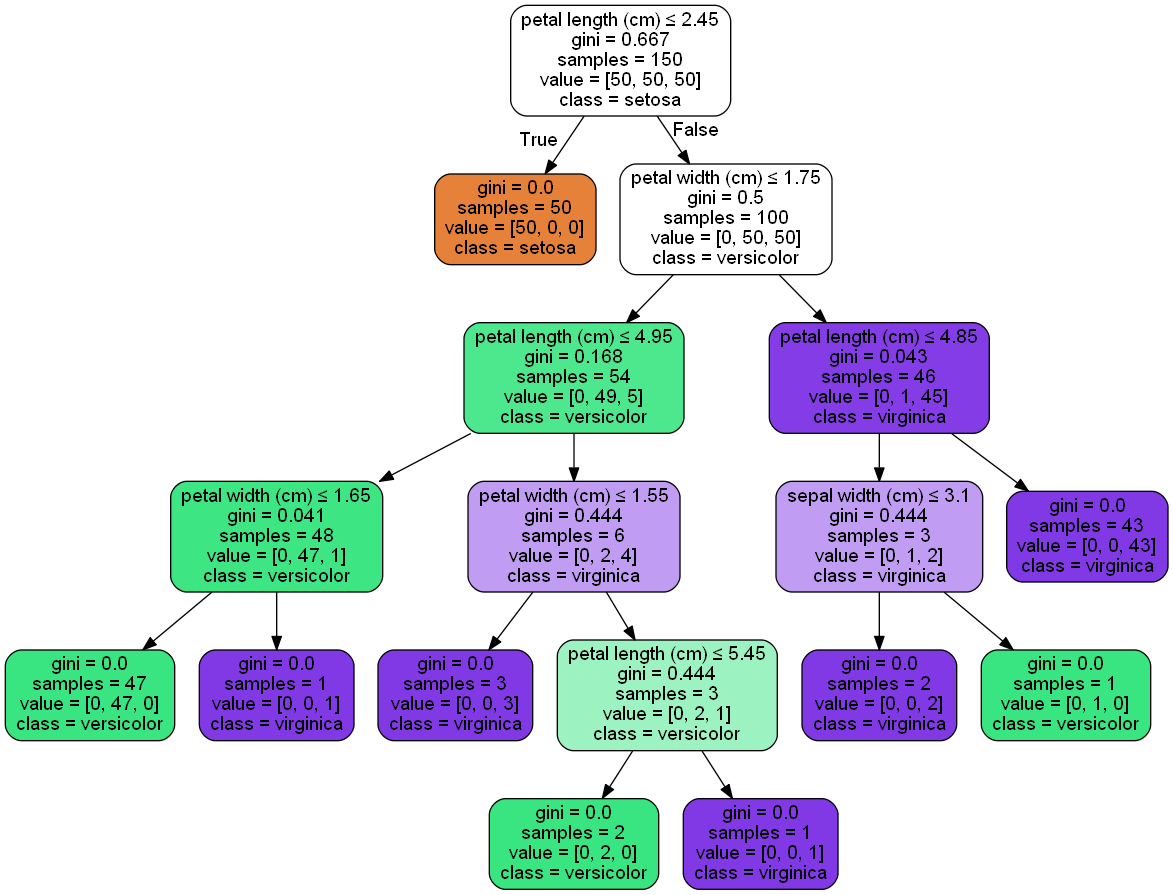

In [18]:
#还可以通过Ipython生成渲染的树形图
from IPython.display import Image 
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=iris.feature_names, 
                         class_names=iris.target_names, 
                         filled=True, rounded=True, 
                         special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [19]:
#由上面例子画海洋生物数据树形图
data = np.array([[1,1],[1,1],[1,0],[0,1],[0,1]])
target =np.array(['yes','yes','no','no','no'])
clf = clf.fit(data,target)
import pydotplus
dot_data = tree.export_graphviz(clf, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("fish.pdf")

True

In [53]:
#np.reshape(-1,1)行数自动算，列数为1
#np.reshape(1,-1)行数为1，列数自动算
clf.predict(np.array([1,0]).reshape(1,-1))

array(['no'], dtype='<U3')

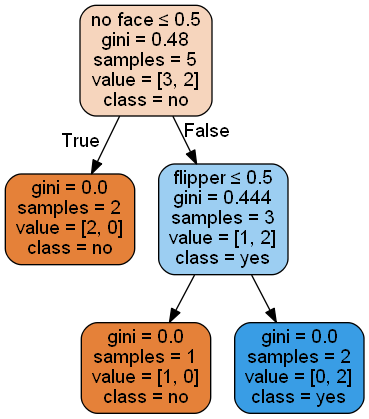

In [56]:
from IPython.display import Image 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=['no face','flipper'], 
                         class_names = ['no','yes'],
                         filled=True, rounded=True, 
                         special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())